In [2]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
from scipy.spatial.transform import Rotation as R

# import pmcpy as mcpy 
import numpy as np
import matplotlib.pyplot as plt
#from pmcpy import so3, Chain, RBP, Pivot, Crankshaft, Dumps, SingleTriad, ClusterTrans
import pmcpy.run.equilibrate as em # actually not equilibrate but energy minimization

# # # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# # import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2

/Users/thor/surfdrive/Projects/PMCpy/pmcpy/Evals/PyLk/pylk/writhemap.py:16: UserWarning: Cython version of writhemap (PyLk) not compiled. Defaulting to numba implementation. Consider compiling the cython version.
  warnings.warn(
/Users/thor/surfdrive/Projects/PMCpy/pmcpy/Evals/PyLk/pylk/eval_link.py:10: UserWarning: Cython version of linkingnumber (PyLk) not compiled. Defaulting to numba implementation. Consider compiling the cython version.
  warnings.warn(


joblib is not installed. Falling back to sequential computation.


In [7]:
control_points = mdna.Shapes.circle(radius=2)
control_points = mdna.Shapes.line(length=1)
spline = mdna.SplineFrames(control_points,nbp=200,closed=False)
dna = mdna.StructureGenerator(spline)
build = mdna.Build(dna)
new_dna = build.equilibrate(closed=False)


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 200

TGTGCGTCGAAGAAATTATGTTCCGCTGCTGGTCCCCGCAATGCGATTTGACGAGTATGCGCTCGTCAGGAGGTAAACGTCTCGCAGAAAGAGACCCTTTGCTTGCCACGAATCGTGGTAGGACACGGGTTTTGTGTCTACATGTGGGCGTTCATTGTTCACAACTTATACGAACAAGTCCAGCTAAAATCACGGTTCGG
cycle 0: 
E = 2499.753592102311 kT
E = 631.9502662559693 kT
E = 596.6400586093595 kT
E = 617.7973277421986 kT


In [8]:
traj = new_dna.get_traj()
view = nv.show_mdtraj(traj)
view

NGLWidget()

In [21]:
out = build.out
out['confs'][0].shape

(100, 3)

In [57]:
control_points = mdna.Shapes.circle(radius=2)
#control_points = mdna.Shapes.line(length=1)
spline = mdna.SplineFrames(control_points,nbp=312,closed=True,dLk=5) 
dna = mdna.StructureGenerator(spline)
build = mdna.Build(dna)
dna = build.equilibrate(closed=True,exvol_rad=0)#_writhe(closed=True)     




Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 312

Structure is requested to be circular:
	Excess twist per base to make ends meet: 0.33 degrees
	New twist angle per base pair: 34.62 

Adjusting twist angles to match the given Delta linking number: 5
	Current twist number: 30.00
	Old twist angle per base pair: 34.62 degrees
	Adjusted twist angle per base pair: 40.38 degrees

TCACGATGTCTTACCTTTGGTGTAGTTCTTCGTGCGCTGCCTGTAAGATCCGCCAAGCTTATGGCTTAAGCTACACATAGCAACGGAGTGTCGAGCTTTCCGTGTGCAGCGGGACACCATCTACCCAGTTGCAATTCTAGAGGAGGGACAAAATGCTTTTCCCCATTTAGTGAATGCAGTATAGAGTTTCAAGCGGATGGTAACTGATTCATTACTTAAACGGGCAAATAGCGGGCCATTTACAGGACCTGGCGCGCAGAGAGAGCCTTTCCTCCTATATGCGGGGATTCGCTTCTGTTCCAGGTTCCCAAA


using numba
34.99999999999996 2.350226801794926 32.64977319820503


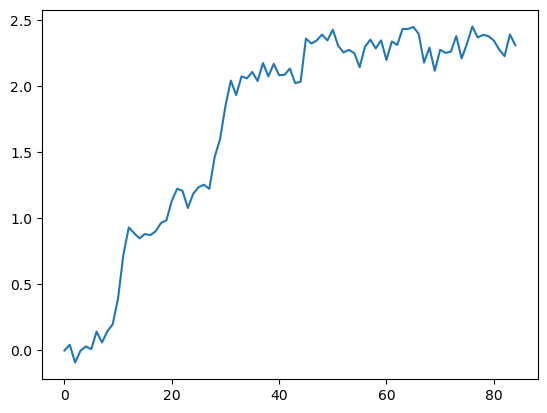

In [53]:
from pmcpy import pylk

confs = build.out['confs']
confs.shape
positions = confs[:,:,:3,3]
triads = confs[:,:,:3,:3]
positions.shape, triads.shape

lk = pylk.triads2link(positions[-1],triads[-1])

writhe = pylk.writhe(positions[-1],closed=True)
print(lk,writhe,lk-writhe)

writhes = [pylk.writhe(pos,closed=False) for pos in positions[::50]]
plt.plot(writhes)
    

In [45]:
lks[-1]

7.0000000000000036

In [38]:
from pmcpy import pylk
# using positions and triads to get mutual linking number
pylk.triads2link??

# computes the linking number between two chains
pylk.linkingnumber


# using positions and triads to get 2 chains
pylk.triads2chain

# positions and closed boolean to get the writhe and extension direction
pylk.writhe??



Object `pylk._eval_lk_python` not found.


Signature:
pylk.writhe(
    pos: numpy.ndarray,
    closed: bool = True,
    num_ext: int = 0,
    ext_dir: numpy.ndarray = None,
)
Docstring: <no docstring>
Source:   
def writhe(pos: np.ndarray, closed: bool = True, num_ext: int = 0, ext_dir: np.ndarray = None):
    if num_ext > 0:
        if ext_dir is None:
            raise ValueError(f'writhe: Extension of the chain requires the extesion direction (ext_dir) to be specified.')
        if closed:
            raise ValueError(f'writhe: Chain extension not supported for closed chain.')  
        ext_pos = np.empty((pos.shape[0]+2*num_ext,pos.shape[1]))
        ext_pos[num_ext:-num_ext] = pos
        disc_len = np.linalg.norm(pos[1]-pos[0])
        for i in range(1,num_ext+1):
            ext_pos[num_ext-i] = ext_pos[num_ext] - i*ext_dir*disc_len
            ext_pos[-num_ext-1+i] = ext_pos[-num_ext-1] + i*ext_dir*disc_len
        pos = ext_pos
    wm = writhemap(pos)
    if not closed:
        wm = wm[:-1,:-1]
    return np.sum(wm)
Fi

In [27]:
traj = dna.get_traj()
view = nv.show_mdtraj(traj)
chain_a = traj.top.select('chainid 0')
chain_b = traj.top.select('chainid 1')
view.clear()
view.add_representation('line', selection=chain_a, color='black')
view.add_representation('line', selection=chain_b, color='gray')
view
# traj.save_pdb('bp120_dlk=-5.pdb')

In [49]:
traj = dna.get_traj()
view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('line')
view

NGLWidget()

(3601, 60, 3) (3601, 60, 3, 3)


(-2.4680083578612475,
 3.9427342991229057,
 -3.1300544483435857,
 3.2806882086405675,
 -1.6904239207722709,
 3.1176330719658436)

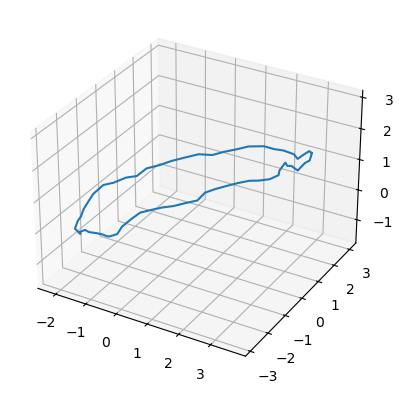

In [11]:
positions = out['confs'][:,:,:3,3]
triads = out['confs'][:,:,:3,:3].transpose(0,1,3,2) # flip column vectors to row vectors
print(positions.shape, triads.shape)

pos = positions[-1]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[:,0],pos[:,1],pos[:,2])
ax.axis('equal')

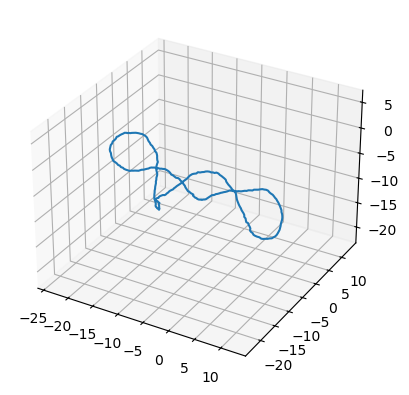

In [11]:
traj = build.get_MC_traj()
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=18)

In [6]:
build = mdna.Build(dna)
new_dna = build.equilibrate()


####################################
Initiating Excluded Volume...

######################################
#### INITIALIZING EXCLUDED VOLUME ####
######################################
 Excluded Volume Beads: 
   number of EV beads: 3
   bp per EV bead:     4
   Effective size:     2.042
   Exclusion distance: 2.4
######################################
cycle 0: 
####################################
Initiating Excluded Volume...

######################################
#### INITIALIZING EXCLUDED VOLUME ####
######################################
 Excluded Volume Beads: 
   number of EV beads: 4
   bp per EV bead:     3
   Effective size:     1.892
   Exclusion distance: 2.4
######################################


ValueError: EVBeads: Overlap detected in intial configuration!


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 24



(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

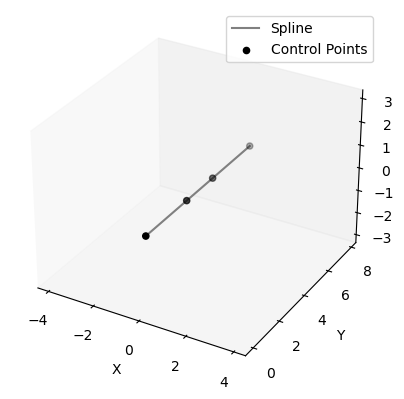

In [2]:
# control_points = mdna.Shapes.trefoil(num_turns=1)
#control_points = mdna.Shapes.helix(radius=1, pitch=0, height=0.5, num_turns=3)
control_points = np.array([[0,0,0],[0,0.75,0],[0,1.25,0],[0,2,0]])
spline = mdna.SplineFrames(control_points,nbp=24,closed=False)
spline.plot_frames(spline=True,triads=False,control_points=True,transparent=True,legend=False)

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

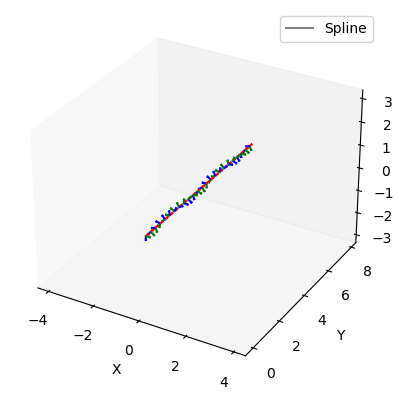

In [3]:
spline.plot_frames(spline=True,triads=True,control_points=False,transparent=True)

In [4]:
import copy
dna = mdna.StructureGenerator(spline)
traj_raw = dna.get_traj()
traj_raw.save('___raw.pdb')

builder = mdna.Build(dna)
new_dna = builder.equilibrate(endpoints_fixed=False)
traj = new_dna.get_traj()

traj.superpose(reference=traj_raw,frame=0)
traj.save('___equilibrated.pdb')

TAGTTAGGCTTGTGGAGACACCCC


/Users/thor/surfdrive/Projects/PMCpy/pmcpy/SO3/so3/SE3.py:17: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  inv[:3,3]  = -inv[:3,:3]@g[:3,3]
/Users/thor/surfdrive/Projects/PMCpy/pmcpy/MCStep/pivot.py:198: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  conf[id-1-i,:3,:3] = G @ conf[id-1-i,:3,:3]


cycle 0: 
8 moves initated
E = 249.63631649150724 kT
E = 79.38220394296795 kT
E = 70.9678480589425 kT
E = 69.26845557912262 kT
E = 67.39937372520099 kT
E = 68.38350438686628 kT
8 moves initated


### Scale spline with set number of bases


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 160



(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

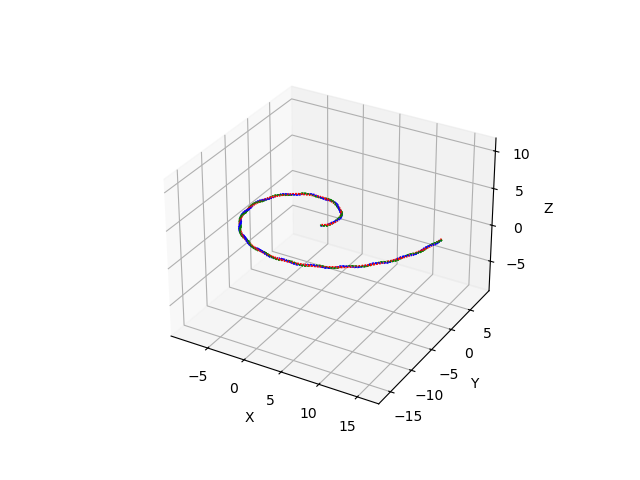

In [316]:
control_points = mdna.Shapes.spiral(radius=1, pitch=1, height=1)
spline = mdna.SplineFrames(control_points,nbp=160)
spline.plot_frames()

### Set dLk (based on twist) of structure


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 120

Structure is requested to be circular:
	Excess twist per base to make ends meet: 1.71 degrees
	New twist angle per base pair: 36.0 

Adjusting twist angles to match the given Delta linking number: 0
	Current twist number: 12.00
	Old twist angle per base pair: 36.00 degrees
	Adjusted twist angle per base pair: 36.00 degrees



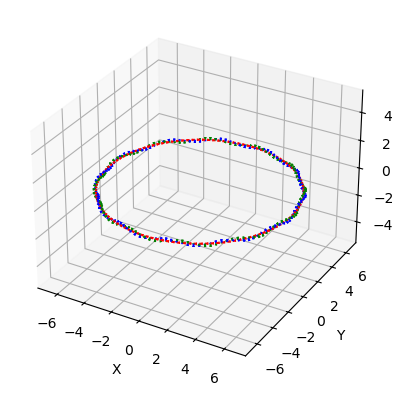

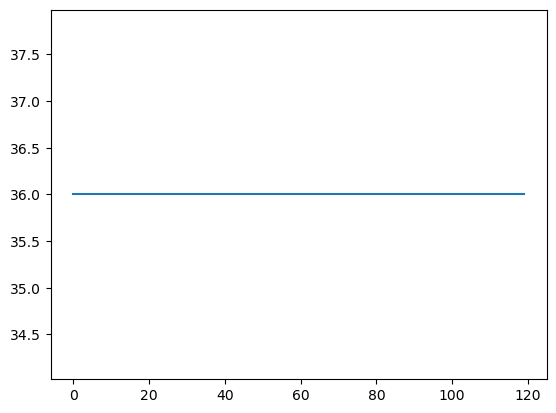

In [453]:
initial_control_points = mdna.Shapes.circle(radius=5)
spline = mdna.SplineFrames(control_points=initial_control_points,
                            nbp=120,
                            closed=True,
                            verbose=False,
                            dLk=0)
spline.plot_frames()
spline.frames.shape
fig, ax = plt.subplots()
ax.plot(spline.twister.twists)

Structure is requested to be circular:
	Excess twist per base to make ends meet: 0.93 degrees
	New twist angle per base pair: 35.22 

Adjusting twist angles to match the given Delta linking number: 0
	Current twist number: 9.00
	Old twist angle per base pair: 35.22 degrees
	Adjusted twist angle per base pair: 35.22 degrees



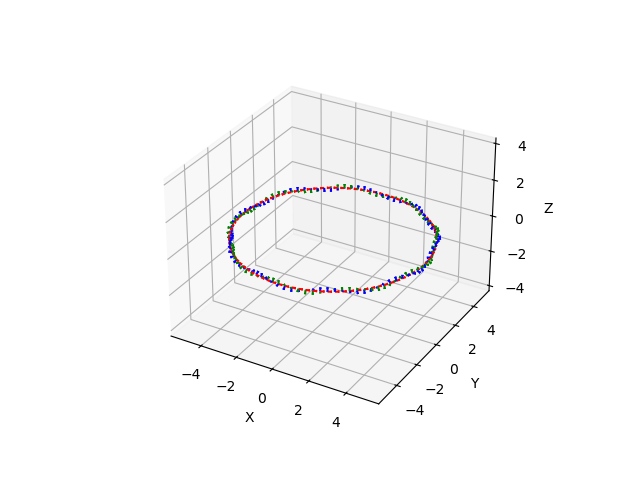

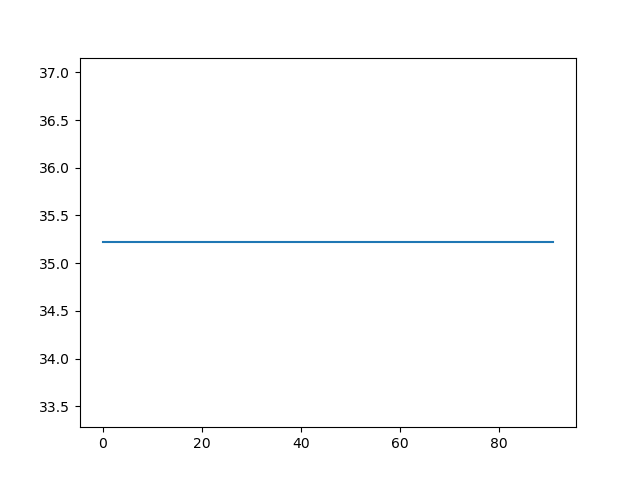

In [421]:
%matplotlib ipympl
initial_control_points = mdna.Shapes.circle(radius=5)
spline = mdna.SplineFrames(control_points=initial_control_points,
                            nbp=None,
                            closed=True,
                            verbose=False,
                            dLk=0)
spline.plot_frames()
spline.frames.shape
fig, ax = plt.subplots()
ax.plot(spline.twister.twists)

In [454]:
dna = mdna.StructureGenerator(spline,circular=True)
build = mdna.Build(dna)
eq = build.equilibrate(closed=True)
traj = eq.get_traj()
nuc = mdna.NucleicFrames(traj)

GTGAATGGAGTACGTCGCGACTGGGATCAACACTGACGTATACCTGAGGGACCTGCCCAAACTGCCCCAAGGGGTGCTTTGCTATATCTGCTATGACTTGATCACTCGGGCAGATCCATG
cycle 0: 
32 moves initated
E = 1552.2748817008585 kT
E = 439.1170982143771 kT
E = 400.1043123423484 kT
E = 396.46506580965377 kT
E = 387.7907219748634 kT
E = 395.34196068271876 kT
32 moves initated


(<Figure size 1000x350 with 12 Axes>,
 array([<Axes: title={'center': 'shear'}>,
        <Axes: title={'center': 'stretch'}>,
        <Axes: title={'center': 'stagger'}>,
        <Axes: title={'center': 'buckle'}>,
        <Axes: title={'center': 'propeller'}>,
        <Axes: title={'center': 'opening'}>,
        <Axes: title={'center': 'shift'}>,
        <Axes: title={'center': 'slide'}>,
        <Axes: title={'center': 'rise'}>, <Axes: title={'center': 'tilt'}>,
        <Axes: title={'center': 'roll'}>,
        <Axes: title={'center': 'twist'}>], dtype=object))

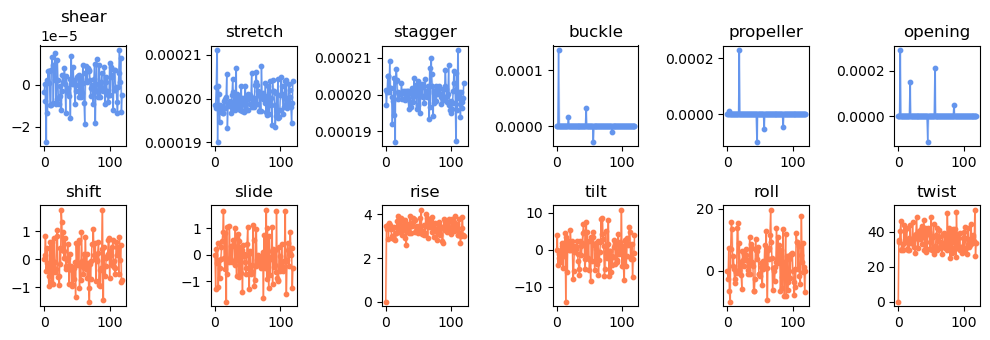

In [455]:
params, names = nuc.get_parameters()
mdna.plot_parameters(params, names)

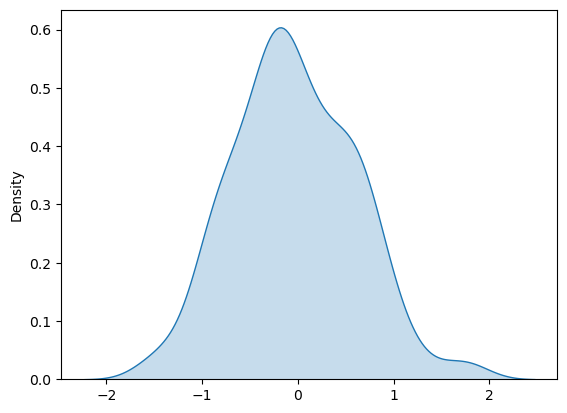

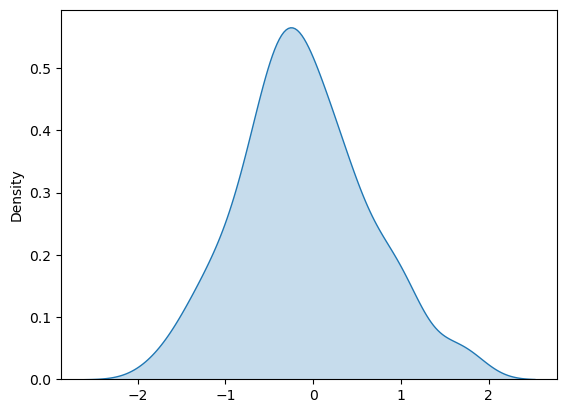

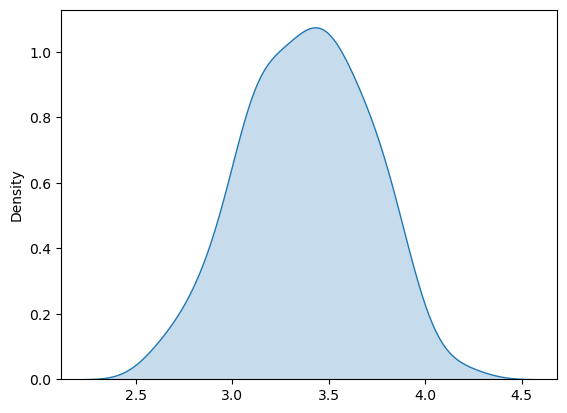

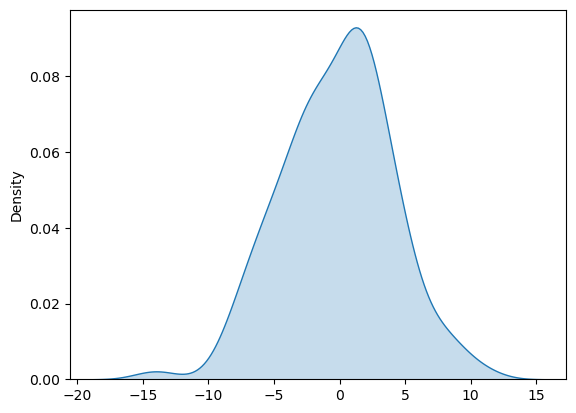

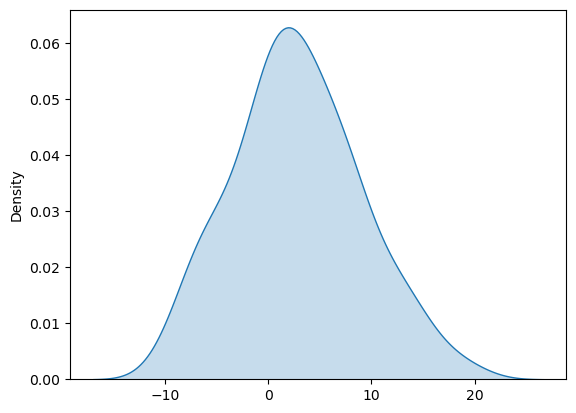

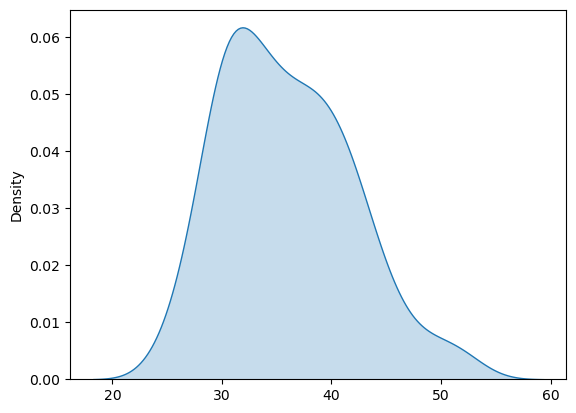

In [456]:
%matplotlib inline

for name in names[6:]:
    param = params[:,1:,names.index(name)][0]
    fig, ax = plt.subplots()
    import seaborn as sns
    sns.kdeplot(param,fill=True)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

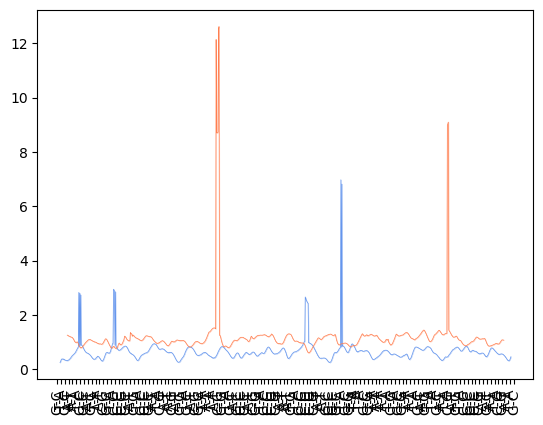

In [457]:
grooves = mdna.GrooveAnalysis(traj)
grooves.plot_groove_widths()


In [ ]:

    def adjust_to_dLk(self):
        """Adjust the twist angles to match the given Delta linking number."""
        current_twist_number = sum(self.twists)/360
        print(f"\tCurrent twist number: {current_twist_number:.2f}")
        old_twist_angle = sum(self.twists) / self.frames.shape[0]
        new_twist_number = np.floor(current_twist_number) + self.dLk
        #print(current_twist_number, new_twist_number, self.dLk)

        # Change the twist angles to match the new twist
        new_twist_angle = new_twist_number * 360 / self.frames.shape[0]
        #print(old_twist_angle, new_twist_angle)
        print(f"\tOld twist angle per base pair: {old_twist_angle:.2f} degrees")
        print(f"\tAdjusted twist angle per base pair: {new_twist_angle:.2f} degrees\n")
        return new_twist_angle


In [108]:
target_bp = 100
n_bp = spline.frames.shape[0]
total_length = spline.arc_length[-1]
ratio = (target_bp*spline.frame_spacing)/total_length
new_control_points = control_points * ratio

new_spline = mdna.SplineFrames(control_points=new_control_points,closed=True,verbose=True)
new_spline.frames.shape

Initializing spline
Evaluating spline
Calculating arc length
Evenly distributing 55 points along the spline and computing derivatives.
Structure is requested to be circular:
 Excess twist per base to make ends meet: 4.99 degrees


(55, 4, 3)

In [88]:
target_bp = 101


initial_arc_length = spline.arc_length[-1]-spline.frame_spacing
predicted_initial_number_of_bp = int(initial_arc_length/spline.frame_spacing)
actual_initial_number_of_bp = spline.frames.shape[0]

print('Predicted number of bp:',predicted_initial_number_of_bp)
print('Initial number of bp:',actual_initial_number_of_bp)

scaling = target_bp/actual_initial_number_of_bp
new_control_points = spline.control_points*scaling
new_spline = mdna.SplineFrames(control_points=new_control_points,closed=True, verbose=True)
new_arc_length = new_spline.arc_length[-1]

actual_number_of_bp = new_spline.frames.shape[0]
predicted_number_of_bp = int(new_arc_length/new_spline.frame_spacing)
print('RESCALING')
print('Predicted number of bp:',predicted_number_of_bp)
print('Actual number of bp:',actual_number_of_bp)

print(len(new_spline.segment_lengths))

# print(number_of_bp,spline.frames.shape,arc_length,scaling)
# #new_control_points = mdna.Shapes.circle(radius=3*scaling)
# #spline = mdna.SplineFrames(control_points=new_control_points,closed=True, verbose=True)
# arc_length = spline.arc_length[-1]
# number_of_bp = int(np.round(arc_length/spline.frame_spacing,0))
# print(number_of_bp,spline.frames.shape,arc_length,scaling)
# if number_of_bp != target_bp:
#     raise ValueError('Number of bp is not correct')
# spline.plot_frames()

Initializing spline
Evaluating spline
Calculating arc length
Evenly distributing 55 points along the spline and computing derivatives.
Structure is requested to be circular:
 Excess twist per base to make ends meet: 4.99 degrees
Predicted number of bp: 54
Initial number of bp: 55
Initializing spline
Evaluating spline
Calculating arc length
Evenly distributing 102 points along the spline and computing derivatives.
Structure is requested to be circular:
 Excess twist per base to make ends meet: 1.01 degrees
RESCALING
Predicted number of bp: 101
Actual number of bp: 102
101


### Equilibrate

In [7]:
circular = True
control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*5
control_points = mdna.Shapes.circle(radius=3)
spline = mdna.SplineFrames(control_points,nbp=100)
dna = mdna.StructureGenerator(spline,circular=circular)
builder = mdna.Build(dna)
new_dna = builder.equilibrate(closed=circular)
traj = new_dna.get_traj()
print(new_dna.sequence)


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 100

GTCCATCCAATGGTATTGGTTATGCAATCGTATCGAGTTTCAGAAACCGACGGAGGCTTCCAGAGGAGGACCGACAGGACTGCTCCCGCAGCGACGGAGT
cycle 0: 
27 moves initated
E = 1650.4242857479364 kT
E = 402.52319795143586 kT
E = 331.53471742517513 kT
E = 328.6914580690781 kT
E = 330.76726755762024 kT
27 moves initated
GTCCATCCAATGGTATTGGTTATGCAATCGTATCGAGTTTCAGAAACCGACGGAGGCTTCCAGAGGAGGACCGACAGGACTGCTCCCGCAGCGACGGAGT


In [15]:
builder = mdna.Build(dna)
builder._test_import()

AttributeError: 'Build' object has no attribute '_test_import'

In [8]:
view = nv.show_mdtraj(builder.get_MC_traj())
view.clear_representations()
view.add_representation('ball+stick', selection='all', color='coral',radius=10)
view

NGLWidget(max_frame=75)

In [4]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('ball+stick')
view

NGLWidget()

### Extend DNA

In [5]:
control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*1
spline = mdna.SplineFrames(control_points)
dna = mdna.StructureGenerator(spline)

CCCTGAGTCC


In [6]:
builder = mdna.Build(dna, five_end='A')
builder.extend(nbp=20)
traj = builder.get_traj()
traj.save('test_extend.pdb')


view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('licorice')
view


cycle 0: 
6 moves initated
E = 336.61122114760917 kT
E = 70.05405563244287 kT
E = 70.43497874224506 kT
6 moves initated
GGGCAATTATACCGAAGTAAGCTGTGATTC


NGLWidget()

In [7]:
view = nv.show_mdtraj(builder.get_MC_traj())
view.clear_representations()
view.add_representation('ball+stick', selection='all', color='coral',radius=3)
view

NGLWidget(max_frame=25)

### Connect DNA's

AGACGGCTTA
TCTGCAATAG


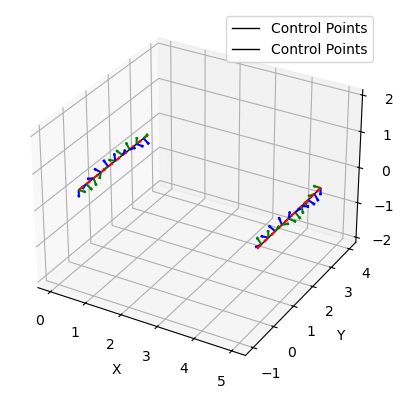

In [48]:
control_points_A = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*1
#control_points_B = control_points_A+5*2
control_points_B = control_points_A + np.array([5,0,0])
control_points_B = control_points_B[::-1]

spline_A = mdna.SplineFrames(control_points_A)
spline_B = mdna.SplineFrames(control_points_B)

dna_a = mdna.StructureGenerator(spline_A)
dna_b = mdna.StructureGenerator(spline_B)


builder = mdna.Build(dna_a, dna_b, five_end='A', three_end='B')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
builder.plot_frames(dna_a, ax)
builder.plot_frames(dna_b, ax)

In [55]:
builder.connect()
traj = builder.get_traj()

Optimal BP: 21, Twist Difference per BP: 0.0 degrees
f [0, 1, 2, 3, 4, 5, 6, 7, 8, 47, 48, 49, 50, 51, 52, 53, 54, 55]
c 56
a 10
b 10
cycle 0: 
9 moves initated
E = 2316.873958649586 kT
E = 1111.9092356545161 kT
E = 645.8464250397362 kT
E = 488.7756713373554 kT
E = 430.57702939812486 kT
E = 400.1964254487602 kT
E = 391.34159894947385 kT
E = 378.10508199594426 kT
E = 379.0022349212935 kT
9 moves initated
GTCAAGCTTTTACAGTCAGGCACATAGACACTCTTGACCTGGTGGAAGCGGAGTAC


In [56]:
view = nv.show_mdtraj(builder.get_MC_traj())
view.clear_representations()
view.add_representation('ball+stick', selection='all', color='coral',radius=3)
view

NGLWidget(max_frame=175)

In [ ]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_licorice(selection='all')
view

NGLWidget()

In [33]:
M = np.array([[0,0,0],[0,4,0],[2,3,0],
              [4,4,0],[4,0,0]])*3

spline = mdna.SplineFrames(M,closed=True)
dna = mdna.StructureGenerator(spline)
traj = dna.get_traj()
view = nv.show_mdtraj(traj)
view

Structure is requested to be circular:
 Excess twist per base to make ends meet: 0.64 degrees
GGGTCTGCCTACGTGGCCTAAGACTCGCAATCGACGTAGGGTCGGAGGTCTGCTTCCGACGTTTGATCCCTTTACCGAATAATAGAGTCCTTTCTCCTCGATGATGTAGTCAGGACGGAATTATAGCGGGAAAG


NGLWidget()

In [ ]:

M = np.array([[0,0,0],[0,4,0],[2,0,0],
              [2,4,0]])*3
spline = mdna.SplineFrames(M,closed=False)
spline.plot_frames()
dna = mdna.StructureGenerator(spline)
traj = dna.get_traj()
view = nv.show_mdtraj(traj)
view
traj.save('N_DNA.pdb')

In [ ]:

D = np.array([[0,0,0],[0,4,0],[3,1,0],
              [1,2,0],[0,0,0]])*3
spline = mdna.SplineFrames(D,closed=True)
spline.plot_frames()
dna = mdna.StructureGenerator(spline)
traj = dna.get_traj()
view = nv.show_mdtraj(traj)
view

In [ ]:
traj.save('A_dna.pdb')